In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from utils.vis_pose import single_pose_image, double_pose_image
from models.st_gcn_VAE_TRUE import Model_VAE as STGCN
from data.ntu_fp import NTU_FP_Dataset
import yaml
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

np.random.seed(0)
torch.manual_seed(0)

In [2]:
sample_pose = np.array([[[ -9.6925],[ -9.7138],  [ -9.7342],  [ -9.6590],  [ -9.8016],  [ -9.7599],  [ -9.6415],  [ -9.6166],  [ -9.6471],  [ -9.7464],  [ -9.6637],  [ -9.6600],  [ -9.7298],  [ -9.7179],  [ -9.7708],  [ -9.6795],  [ -9.6637],  [ -9.6854],  [ -9.8038],  [ -9.7618],  [ -9.7288],  [ -9.5601],  [ -9.6628],  [ -9.6414],  [ -9.6814]], [[ -9.4176],  [ -9.1423],  [ -8.8762],  [ -8.7473],  [ -9.0178],  [ -9.2648],  [ -9.4551],  [ -9.5253],  [ -8.9135],  [ -8.9440],  [ -9.1617],  [ -9.2640],  [ -9.4258],  [ -9.7777],  [-10.0827],  [-10.1436],  [ -9.4189],  [ -9.8132],  [-10.0374],  [-10.1059],  [ -8.9412],  [ -9.5811],  [ -9.5185],  [ -9.2959],  [ -9.2589]], [[-78.1498],  [-78.2781],  [-78.4164],  [-78.4354],  [-78.4724],  [-78.4383],  [-78.3339],  [-78.2619],  [-78.2031],  [-78.5201],  [-78.3114],  [-78.3320],  [-78.2227],  [-78.0755],  [-77.8429],  [-77.8968],  [-78.1462],  [-78.0775],  [-77.8681],  [-77.9534],  [-78.3797],  [-78.2327],  [-78.2500],  [-78.2995],  [-78.3750]]])

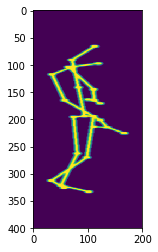

In [3]:
sample_pose = sample_pose.reshape(3,25).transpose(1,0)
image_sample = single_pose_image(sample_pose)
plt.imshow(image_sample)

In [4]:
save_path = './work_dir/ntu-xsub/FP_GCN_VAE_relative/trained_stgcn.pt'
config = "config/fp_gcn/ntu_fp/train.yaml"
num_future=20

In [5]:
with open(config, 'r') as f:
    print("Loading config from:", config)
    args = yaml.load(f)

test_feeder_args = args["test_feeder_args"]
test_dataset = NTU_FP_Dataset(**test_feeder_args)   
test_loader = DataLoader(  dataset=test_dataset,
                            batch_size=1,#args["batch_size"],
                            shuffle=True,
                            num_workers=1,
                            drop_last=True) 

devices = args["device"]
model_args = args["model_args"]
stgcn = STGCN(**model_args)

Loading config from: config/fp_gcn/ntu_fp/train.yaml


In [6]:
stgcn.load_state_dict(torch.load(save_path))

if torch.cuda.is_available():
    stgcn = stgcn.cuda()

19662
label tensor([[37]], device='cuda:0')
length tensor([56])


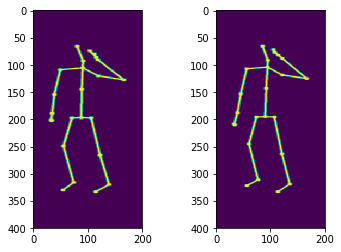

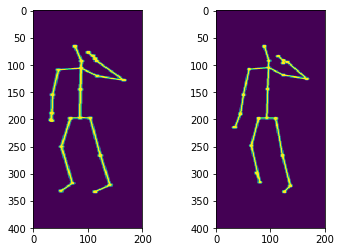

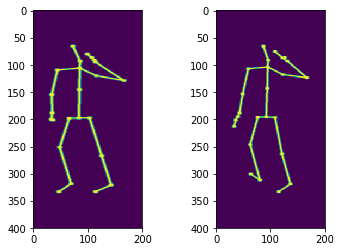

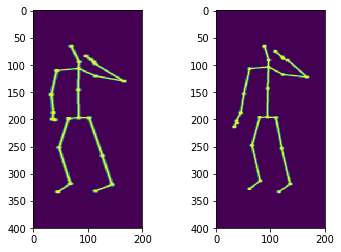

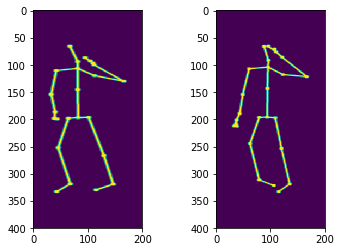

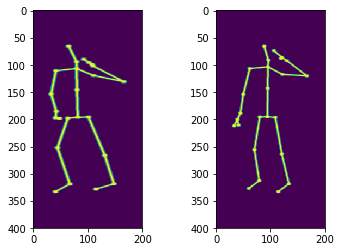

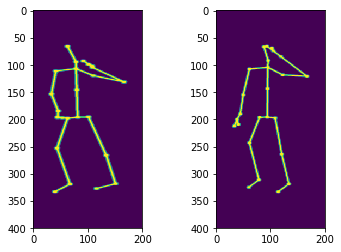

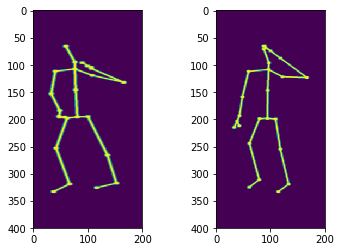

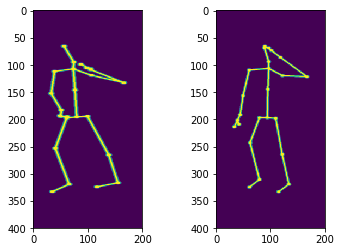

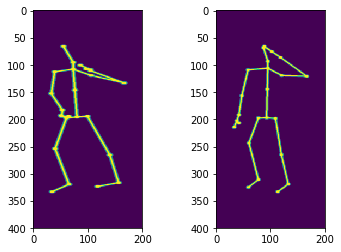

In [11]:
criterion = nn.MSELoss()

print(len(test_loader))
for i, (data, label, length) in enumerate(test_loader):
    # get data
    if torch.cuda.is_available():
        data = data.float().cuda()
        label = label.long().cuda()
    # forward
    past_pose_input = data[:,:, :length-num_future, :, :]
    past_pose_output = data[:,:, 1:length-num_future+1, :, :]
    past_velocities = data[:,:, 1:length-num_future+1, :, :] - data[:,:, :length-num_future, :, :]
    future_pose_input = data[:,:, length-num_future:length-num_future+1, :, :]
    
    future_pose_output = data[:,:, length-num_future+1:length, :, :]
    future_velocities = data[:,:, length-num_future+1:length, :, :] - data[:,:, length-num_future:length-1, :, :]
    future_predicted = stgcn(past_pose_input, past_velocities, future_pose_input, T_future = future_velocities.shape[2], train=False) 
    loss_mse = criterion(future_predicted, future_velocities)
    loss = loss_mse*10
    # statistics
    now_loss = loss.data.item()  / (data.shape[2] - num_future)
    #print("loss: %.5f \r" % (now_loss))

    if label.data==37:
        print("label", label)
        print("length", length)
        
        poses = torch.zeros(future_pose_output.shape).cuda()
        cur_pose = future_pose_input
        for k in range(poses.shape[2]):
            cur_pose = cur_pose + future_predicted[:,:,k:k+1,:,:]
            poses[:,:,k,:,:] = cur_pose.squeeze(2)

        Cols = 1

        for j in range(poses.shape[2]):
            if torch.cuda.is_available():
                #image = double_pose_image(data[:,:,i+num_future,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0),
                #                          output[:,:,i,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0))
                pred_pose = poses[:,:,j,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0)
                gt_pose = future_pose_output[:,:,j,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0)
                #pose = future_pose_input.cpu().detach().numpy().reshape(3,25).transpose(1,0)
                pred_image = single_pose_image(pred_pose)
                gt_image = single_pose_image(gt_pose) 
            if j%(2*Cols) == 0:
                fig, ax = plt.subplots(1,2*Cols)

            ax[(2*j)%(2*Cols)].imshow(pred_image)
            ax[(2*j+1)%(2*Cols)].imshow(gt_image)
            plt.savefig("imgs/img"+str(j)+".png")
        plt.show()
        break
    